In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv('JPlace_002.csv')
df.drop(['Annual 24-hr Avg.'], axis=1, inplace=True)
dfLong = pd.melt(df, id_vars=['YEAR'], value_vars=['Jan', 'Feb', 'Mar', 'Apr', 'May','Jun','Jul','Aug','Sep', 'Oct','Nov','Dec']).sort_values(by=['YEAR'])
dfLong.columns = ['year', 'month_name', 'count']
dfLong['day'] = 1

def coding(col, codeDict):
    colCoded = pd.Series(col, copy=True)
    for key, value in codeDict.items():
        colCoded.replace(key, value, inplace=True)
    return colCoded
dfLong['month'] = coding(dfLong['month_name'], {'Jan':1, 'Feb':2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7, 'Aug':8, 'Sep': 9, 'Oct':10, 'Nov':11, 'Dec':12})
dfLong = dfLong.sort_values(by=['year', 'month'])
dfLong['date'] = pd.to_datetime(dfLong[['year', 'month', 'day']])
dfLong.set_index('date', inplace=True)

dfLong = dfLong.convert_objects(convert_numeric=True)


C:\Users\christopher\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


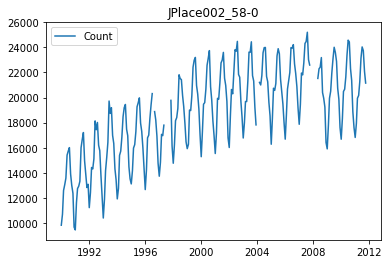

In [2]:

fig = plt.figure()
ax = plt.subplot(111)
ax.plot(dfLong.index, dfLong['count'], label='Count')
plt.title('JPlace002_58-0')
ax.legend()


In [3]:
dfLongFill = dfLong.fillna(method='pad')

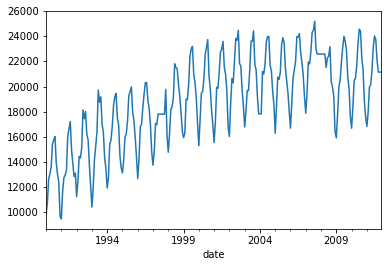

In [4]:
dfLongFill['count'].plot()

In [5]:
dfLongFill.head()

,year,month_name,count,day,month
date,,,,,
1990-01-01,1990,Jan,9836.0,1,1
1990-02-01,1990,Feb,10712.0,1,2
1990-03-01,1990,Mar,12600.0,1,3
1990-04-01,1990,Apr,13064.0,1,4
1990-05-01,1990,May,13584.0,1,5


In [5]:
time_series = dfLongFill['count']

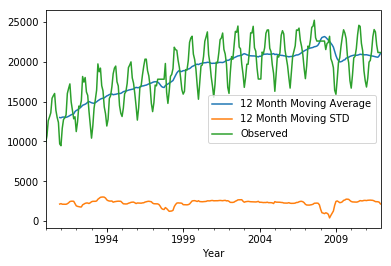

In [88]:
time_series.rolling(12).mean().plot(label='12 Month Moving Average')
time_series.rolling(12).std().plot(label='12 Month Moving STD')
time_series.plot(label='Observed')
plt.legend()
plt.xlabel('Year')
plt.savefig('site2ma')

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

C:\Users\cfelt\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [8]:
decomp = seasonal_decompose(dfLongFill['count'])

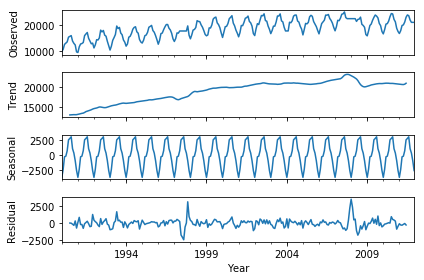

In [89]:
fig = decomp.plot()
plt.xlabel('Year')
fig.savefig('site2decomp.png')

In [43]:
from statsmodels.tsa.stattools import adfuller

In [21]:
def adf_check(time_series):
    result = adfuller(time_series)
    print("Augmented Dicky-Fuller Test")
    labels = ['ADF Test Statistic', 'p-value', '# of lags', 'Num of Observations used']
    
    for value, label in zip(result, labels):
        print(label+' : '+str(value))
        
    if result[1] <= 0.05:
        print("Strong evidence against null hypothesis")
        print('reject null hpothesis')
        print('Data has no unit root and is stationary')
    else:
        print('weak evidence against null hypothesis')
        print('Fail to reject null hypothesis')
        print('Data has a unit root, it is non-stationary')

In [22]:
adf_check(dfLongFill['count'])

Augmented Dicky-Fuller Test
ADF Test Statistic : -2.18080016862
p-value : 0.213287534458
# of lags : 12
Num of Observations used : 251
weak evidence against null hypothesis
Fail to reject null hypothesis
Data has a unit root, it is non-stationary


In [23]:
dfLongFill['first_dif'] = dfLongFill['count'] - dfLongFill['count'].shift(1)

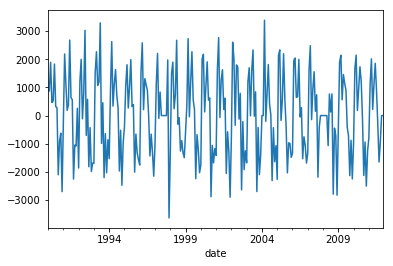

In [24]:
dfLongFill['first_dif'].plot()

In [25]:
adf_check(dfLongFill['first_dif'].dropna())

Augmented Dicky-Fuller Test
ADF Test Statistic : -5.95424040118
p-value : 2.11171521367e-07
# of lags : 11
Num of Observations used : 251
Strong evidence against null hypothesis
reject null hpothesis
Data has no unit root and is stationary


In [26]:
dfLongFill['season_dif'] = dfLongFill['count'] - dfLongFill['count'].shift(12)

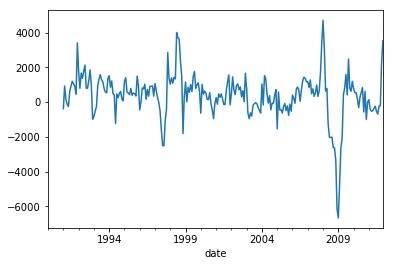

In [27]:
dfLongFill['season_dif'].plot()

In [28]:
adf_check(dfLongFill['season_dif'].dropna())

Augmented Dicky-Fuller Test
ADF Test Statistic : -3.64356971349
p-value : 0.00498066569009
# of lags : 12
Num of Observations used : 239
Strong evidence against null hypothesis
reject null hpothesis
Data has no unit root and is stationary


In [29]:
dfLongFill['season_first_dif'] = dfLongFill['first_dif'] - dfLongFill['first_dif'].shift(12)

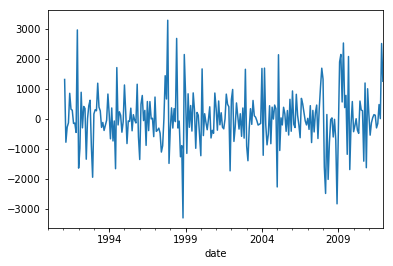

In [30]:
dfLongFill['season_first_dif'].plot()

In [31]:
adf_check(dfLongFill['season_first_dif'].dropna())

Augmented Dicky-Fuller Test
ADF Test Statistic : -8.09940491122
p-value : 1.31215841936e-12
# of lags : 11
Num of Observations used : 239
Strong evidence against null hypothesis
reject null hpothesis
Data has no unit root and is stationary


In [32]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

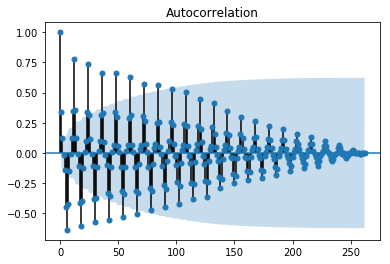

In [33]:
fig_first = plot_acf(dfLongFill['first_dif'].dropna())

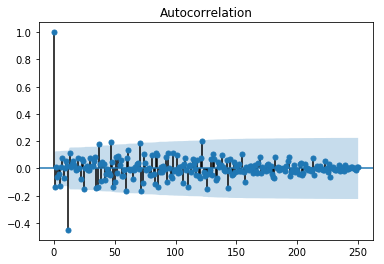

In [34]:
fig_first = plot_acf(dfLongFill['season_first_dif'].dropna())

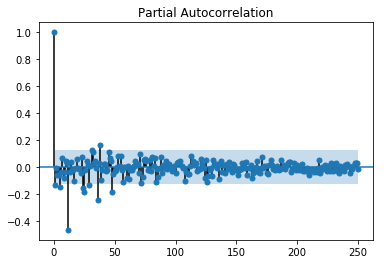

In [35]:
fig_first = plot_pacf(dfLongFill['season_first_dif'].dropna())

In [11]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

### Redo Stars** after studying 

In [50]:
# model = sm.tsa.statespace.SARIMAX(dfLongFill['count'], order=(0,1,0), seasonal_order=(1,1,1,12)) #**
model = sm.tsa.statespace.SARIMAX(dfLongFill['count'], order=(0,1,0), seasonal_order=(1,1,1,12)) #**

In [51]:
results = model.fit()   #**

In [52]:
print(results.summary())  #**

                                 Statespace Model Results                                 
Dep. Variable:                              count   No. Observations:                  264
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 12)   Log Likelihood               -2013.917
Date:                            Tue, 13 Mar 2018   AIC                           4033.834
Time:                                    12:50:10   BIC                           4044.562
Sample:                                01-01-1990   HQIC                          4038.145
                                     - 12-01-2011                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.1509      0.048      3.165      0.002       0.057       0.244
ma.S.L12      -0.9984      0.058   

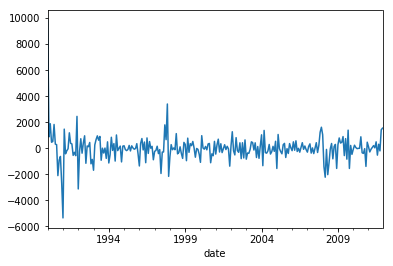

In [53]:
results.resid.plot()  #**

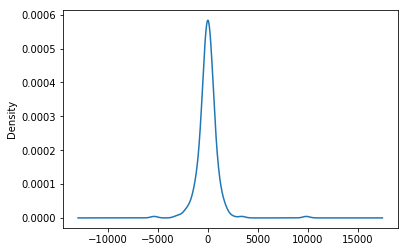

In [54]:
results.resid.plot(kind='kde') #**

In [55]:
from pandas.tseries.offsets import DateOffset 

In [92]:
future_dates = [dfLongFill.index[-1]+DateOffset(months=x) for x in range(1,96)] #add the number that reaches say 2019 #**

In [93]:
future_df = pd.DataFrame(index=future_dates, columns=dfLongFill.columns)  #**

In [94]:
final_df = pd.concat([dfLongFill, future_df])  #**

In [95]:
final_df.head()

,year,month_name,count,day,month
1990-01-01,1990,Jan,9836.0,1,1
1990-02-01,1990,Feb,10712.0,1,2
1990-03-01,1990,Mar,12600.0,1,3
1990-04-01,1990,Apr,13064.0,1,4
1990-05-01,1990,May,13584.0,1,5


In [96]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 359 entries, 1990-01-01 to 2019-11-01
Data columns (total 5 columns):
year          264 non-null object
month_name    264 non-null object
count         264 non-null float64
day           264 non-null object
month         264 non-null object
dtypes: float64(1), object(4)
memory usage: 16.8+ KB


In [99]:
final_df['forecast']=results.predict(start=264, end=360)

In [100]:
final_df['forecast_trend'] = final_df['forecast'].fillna(dfLongFill['count'])

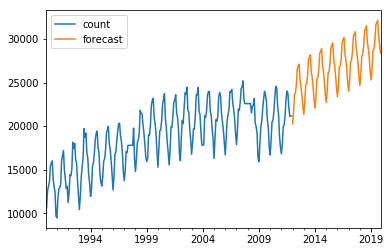

In [101]:
final_df[['count', 'forecast']].plot()

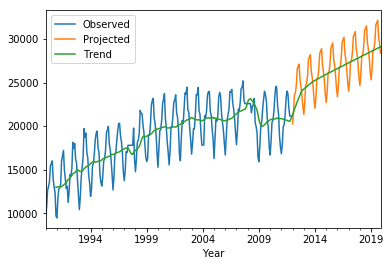

In [102]:
final_df['count'].plot(label='Observed')
final_df['forecast'].plot(label='Projected')
final_df['forecast_trend'].rolling(12).mean().plot(label='Trend')
plt.xlabel('Year')
plt.legend()

plt.savefig('site2project.png')